# Imports

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time

from tensorflow.keras.layers import Lambda
from keras.backend import slice

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Ploting
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Loading

In [0]:
!git clone https://github.com/grudloff/stock_market_GAN.git

Cloning into 'stock_market_GAN'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [0]:
data_names = ["S&P500","SSE","IBM","MSFT","PAICC"]
data_name = data_names[0]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)

stock_market_GAN/datasets/S&P500.csv


In [0]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03
mean,1495.419580,1504.207347,1485.896934,1495.566086,1495.566086,2.954812e+09
std,499.462791,499.894439,498.801221,499.378368,499.378368,1.545804e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.121200e+08
25%,1151.739990,1159.934998,1142.179993,1151.629944,1151.629944,1.488865e+09
50%,1334.369995,1343.319946,1325.689941,1334.219971,1334.219971,3.078530e+09
75%,1806.269959,1810.450012,1800.674988,1805.450012,1805.450012,3.886925e+09
max,2936.760010,2940.909912,2927.110107,2930.750000,2930.750000,1.145623e+10


In [0]:
dataframe.shape

(5031, 7)

In [0]:
def add_Ma(dataframe):
  Ma_window=5
  for i in range(0,dataframe.shape[0]-Ma_window):
    dataframe.loc[dataframe.index[i+Ma_window],'Ma'] = np.round(((dataframe.iloc[i,4]+ dataframe.iloc[i+1,4] +dataframe.iloc[i+2,4] + dataframe.iloc[i+3,4]+ dataframe.iloc[i+4,4])/5),6)
  return dataframe[5:-5]

dataframe=add_Ma(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ma
5,1999-01-11,1275.089966,1276.219971,1253.339966,1263.880005,1263.880005,818000000,1258.007983
6,1999-01-12,1263.880005,1264.449951,1238.290039,1239.510010,1239.510010,800200000,1265.163989
7,1999-01-13,1239.510010,1247.750000,1205.459961,1234.400024,1234.400024,931500000,1264.109985
8,1999-01-14,1234.400024,1236.810059,1209.540039,1212.189941,1212.189941,797200000,1256.521997
9,1999-01-15,1212.189941,1243.260010,1212.189941,1243.260010,1243.260010,798100000,1245.013989


In [0]:
np.where(dataframe.to_numpy()==0)

(array([], dtype=int64), array([], dtype=int64))

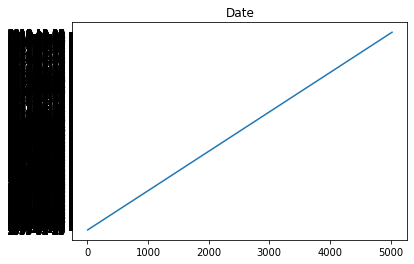

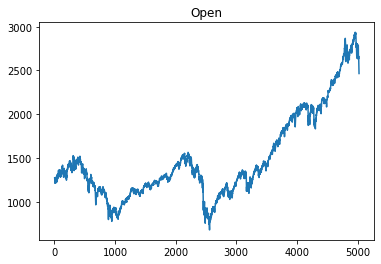

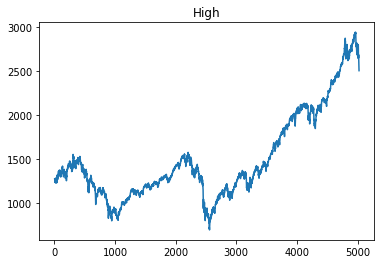

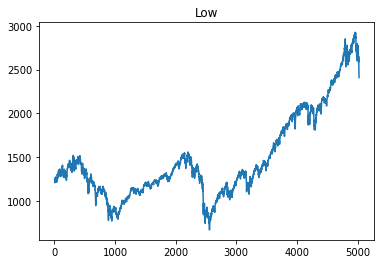

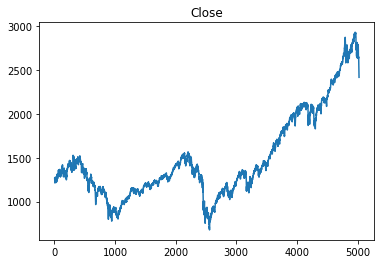

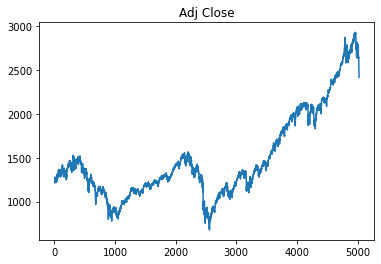

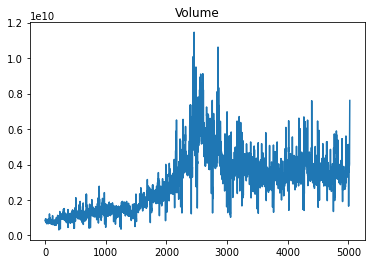

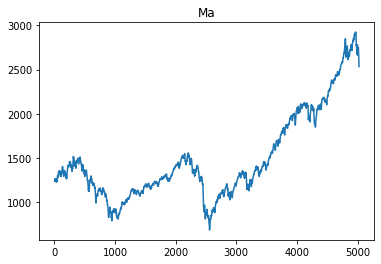

In [0]:
def plot_dataframe(dataframe):
  for column_name in dataframe.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(dataframe[column_name])

plot_dataframe(dataframe)

# Preprocessing

In [0]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    #targets = (targets - mean[..., 3])/std[..., 3] # The close value is our target
    targets = (targets - mean)/std # The close value is our target
    return samples, targets

In [0]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
#targets = np.array([[i**4] for i in range(11)])
targets = data

print(targets.shape)

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = np.int))
print(y*std+mean)

(11, 4)
[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[[   10.   100.  1000. 10000.]]


In [0]:
data.shape

(11, 4)

In [0]:
n_sequence = 5
n_features = 7
n_batch = 32

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  #targets = data[:,3, None] #add none to have same number of dimensions as data
  targets = data
  n_samples = data.shape[0]
  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

  return data_gen_train, data_gen_test

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

In [0]:
data_gen_train[0]

(array([[[ 0.44692554,  0.37099073,  0.74290198, ...,  0.31563888,
          -0.76228304,  1.12700496],
         [-0.04384866, -1.36147989, -0.80239256, ..., -1.23311117,
           0.2683826 ,  0.59648813],
         [-1.80076501,  0.8940475 , -0.62102039, ...,  1.44455991,
          -0.53976847, -1.83194868],
         [ 1.23680977,  1.09816535,  1.60260427, ...,  0.49610905,
          -0.81006224,  0.13215233],
         [ 0.16087836, -1.00172368, -0.9220933 , ..., -1.02319666,
           1.84373114, -0.02369674]],
 
        [[-1.36164344, -1.33809071, -0.71973655, ..., -0.90199769,
           0.25057291, -0.83574817],
         [-0.2122983 , -0.77391288, -0.55729945, ..., -1.34852568,
          -1.6242172 , -0.15410135],
         [-0.62943238, -0.02511548, -0.03248539, ...,  0.10602456,
           1.20599479, -1.14880822],
         [ 0.72936816,  0.66463977, -0.6322743 , ...,  0.90313424,
           0.72828385,  0.49006686],
         [ 1.47400595,  1.4724793 ,  1.9417957 , ...,  1.2413

In [0]:
# test on data
data = dataframe.drop(columns='Date').to_numpy()
targets = data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)


x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5] - mean)/std
print(x)
print(y)

assert (x_gen == x).all()
assert (y_gen == y).all()

[[[ 1.35021737  1.55240795  1.57772257  1.52058438  1.52058438
   -0.21230347  0.03394391]
  [ 0.84696243  0.741117    0.77488824  0.05194838  0.05194838
   -0.55584909  1.02784084]
  [-0.24709317 -0.40998716 -0.97642349 -0.25600036 -0.25600036
    1.97828236  0.88145033]
  [-0.47649858 -1.16406193 -0.75877282 -1.59447119 -1.59447119
   -0.61375004 -0.17244453]
  [-1.47358806 -0.71947586 -0.61741451  0.27793879  0.27793879
   -0.59637976 -1.77079056]]]
[[-0.07874235 -0.02949994  0.59458278  0.80464648  0.80464648 -0.83956373
  -2.65496239]]
[[[ 1.35021737  1.55240795  1.57772257  1.52058438  1.52058438
   -0.21230347  0.03394391]
  [ 0.84696243  0.741117    0.77488824  0.05194838  0.05194838
   -0.55584909  1.02784084]
  [-0.24709317 -0.40998716 -0.97642349 -0.25600036 -0.25600036
    1.97828236  0.88145033]
  [-0.47649858 -1.16406193 -0.75877282 -1.59447119 -1.59447119
   -0.61375004 -0.17244453]
  [-1.47358806 -0.71947586 -0.61741451  0.27793879  0.27793879
   -0.59637976 -1.77079056

# Baseline 

In [0]:
# baseline: use previous day as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,3])
baseline_error

3.586416641431895

In [0]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

3.59109039217068

# Utilities

In [0]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)


#class ar(tf.keras.metrics.Metric):
#  def __init__(self, name="ar", **kwargs):
#    super(ar, self).__init__(name=name, **kwargs)
#    self.y_old = self.add_weight(name='y_old', shape=n_batch, initializer='zeros', dtype=tf.float32)
#    self.y_true = self.add_weight(name='y_true', shape=n_batch, initializer='zeros', dtype=tf.float32)
#    self.y_pred = self.add_weight(name='y_pred', shape=n_batch, initializer='zeros', dtype=tf.float32)

#  def update_state(self, y_true, y_pred, sample_weight = None):
#    self.y_true = y_true[:,3]
#    self.y_pred = y_pred[:,3]
#    # shape y : (batch_size, n_features)
#    self.y_old = tf.stack([self.y_old[-1] , self.y_true[:-1]], 0)

#  def result(self):
#    mask = tf.cast(self.y_pred > self.y_old, tf.float32)
#    return tf.reduce_mean((self.y_true - self.y_old)*mask)

   
  
  

In [0]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
#def mape(y_true, y_pred):
#    return tf.keras.backend.mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
#    # ***The absolute is over the whole thing as y_true can be negative

#def rmse(y_true, y_pred):
#    return tf.sqrt(tf.keras.backend.mean(tf.square(y_true-y_pred)))

#def ar(y_true, y_pred):
#    N = tf.cast(tf.size(y_true), tf.float32)
#    return tf.keras.backend.sum(tf.keras.backend.maximum(y_true-y_pred, 0)) / (N-1)

# GAN

## Perdidas

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [0]:
def make_generator_model():

  inputs = Input(shape=(n_sequence, n_features,))
  lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
  batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
  lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
  lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
  lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
  batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
  lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
  lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
  #lstm_3 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_2_droput)
  #batch_norm3=tf.keras.layers.BatchNormalization()(lstm_3)
  #lstm_3_LRelu = LeakyReLU(alpha=0.3)(batch_norm3) 
  #lstm_3_droput = Dropout(0.3)(lstm_3_LRelu)
  #lstm_4 = LSTM(units=100, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_3_droput)
  #batch_norm4=tf.keras.layers.BatchNormalization()(lstm_4)
  #lstm_4_LRelu = LeakyReLU(alpha=0.3)(batch_norm4) 
  #lstm_4_droput = Dropout(0.5)(lstm_4_LRelu)
  output_dense = Dense(n_features, activation=None)(lstm_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 

  #prediction = Lambda( lambda x: x[..., 3:4])(output)
  #slice_model = Model(inputs = inputs, outputs = prediction)
  #slice_model.compile(loss='mse', metrics = ['mse', 'mae', 'mape', rmse, ar])
  #slice_model.summary()

  model = Model(inputs = inputs, outputs = output)
  #model.compile(loss=generator_loss)
  model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
  #model.compile(loss=None, metrics = [mse , mae, mape, rmse])
  model.summary()

  #return model, slice_model
  return model

  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  


In [0]:
generator = make_generator_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 10)             720       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 10)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40    

## Discriminator

In [0]:
def make_discriminator_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
  model.add(Dropout(0.3))
  model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(1 ,activation='sigmoid'))
  model.compile(loss=discriminator_loss)
  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  return model


In [0]:
discriminator=make_discriminator_model()

In [0]:
learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

## Training

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 2000

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

def train_step_def(sequences, sequences_end):
  # sequences is the real output

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_prediction = generator(sequences, training=True)

    sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

    real_output = discriminator(sequences_true, training=True)
    fake_output = discriminator(sequences_fake, training=True)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                            sequences_end, 
                                            fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
  generated_prediction = generator(sequences, training=False)

  sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
  sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

  real_output = discriminator(sequences_true, training=False)
  fake_output = discriminator(sequences_fake, training=False)

  gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
  disc_loss = discriminator_loss(real_output, fake_output)
  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [0]:
#@tf.function
#def train_step(sequences, sequences_end):
#  return train_step_def(sequences, sequences_end)

#@tf.function
#def test_step(sequences, sequences_end):
#  return test_step_def(sequences, sequences_end)

In [0]:
def train(dataset, dataset_val, epochs):
  history = np.empty(shape = (8, epochs))
  history_val = np.empty(shape = (8, epochs))
  len_dataset = len(dataset)
  len_dataset_val = len(dataset_val)
  for epoch in range(epochs):
    start = time.time()

    cur_dis_loss = 0
    cur_gen_loss = 0
    cur_gen_mse_loss = 0
    for sequence_batch, sequence_end_batch in dataset:
      aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                  tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss += aux_cur_losses[0]/len_dataset
      cur_dis_loss += aux_cur_losses[1]/len_dataset
      cur_gen_mse_loss += aux_cur_losses[2]/len_dataset

    #cur_gen_loss = generator.evaluate(dataset,verbose=False)
    cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]
    #cur_dis_loss = discriminator.evaluate(dataset,verbose=False)

    history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics
    #history[:, epoch] = cur_gen_loss, *cur_gen_slice_metrics

    #cur_gen_loss_val = generator.evaluate(dataset_val,verbose=False)
    cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

    #cur_dis_loss_val = discriminator.evaluate(dataset_val,verbose=False)

    cur_gen_loss_val = 0
    cur_dis_loss_val = 0
    cur_gen_mse_loss_val = 0
    for sequence_batch, sequence_end_batch in dataset_val:
      aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                     tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
      cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
      cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


    history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

    print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
           .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))
      
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  return history, history_val

In [0]:
#history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

## Visualization

In [0]:
metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']

def plot_history(history, history_val):
  for i, metric_name in enumerate(metrics):  
    plt.figure()
    plt.title(metric_name)
    plt.plot(history[i], label='train')
    plt.plot(history_val[i], label='test')
    plt.legend()
  plt.show()

#plot_history(history, history_val)

In [0]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)[...,3]
  y_true = target[...,3]

  plt.figure()
  plt.title("closing price")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], generator)

In [0]:
def get_best_results(history):
  # get best mse
  min_index = np.argmin(history[3, :])

  return history[:, min_index]

#get_best_results(history_val)

# Test on all datasets

In [0]:
results = np.zeros((5,8))

#S&P500

stock_market_GAN/datasets/S&P500.csv
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5, 10)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_3 

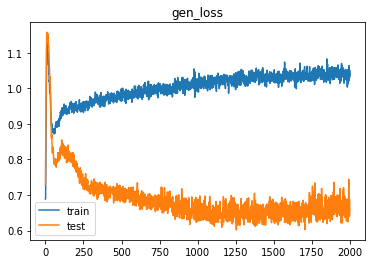

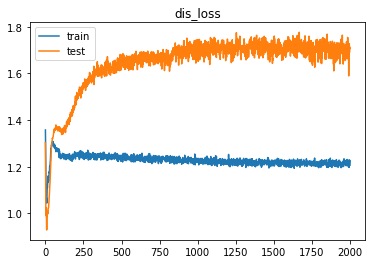

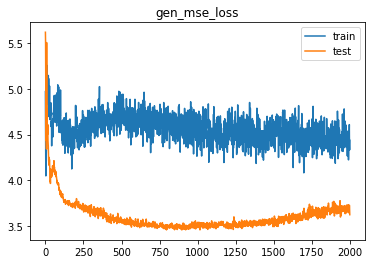

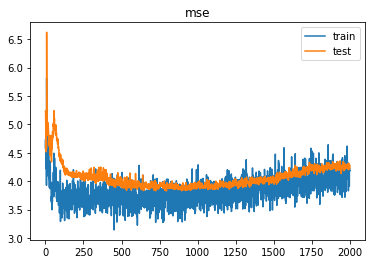

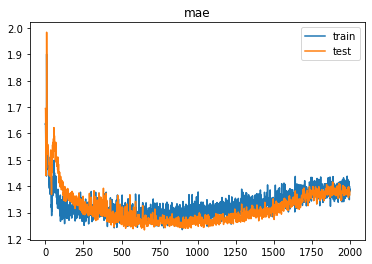

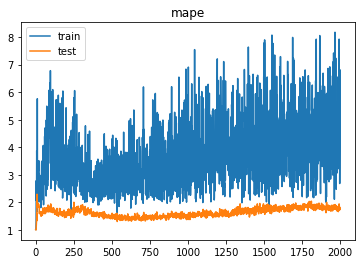

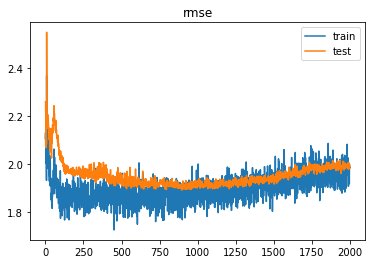

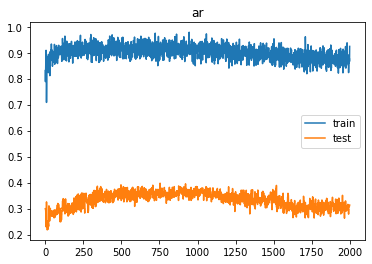

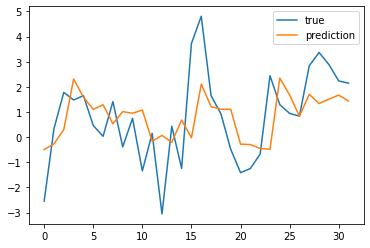

[MSE Baseline] train: 3.459208134959418  test: 3.925046575331633
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.65767938 1.70234072 3.45734262 3.82763624 1.25904489 1.64990997
 1.89392006 0.32034546]


In [0]:
i = 0
data_name = data_names[i]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

#SSE

stock_market_GAN/datasets/SSE.csv
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_5 (Ba

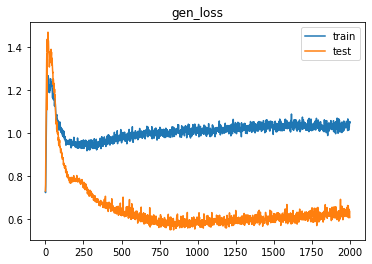

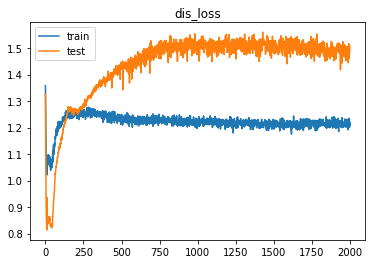

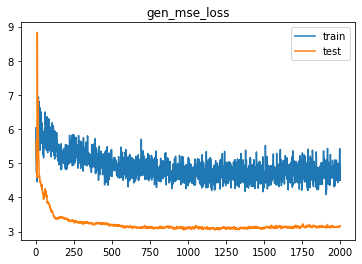

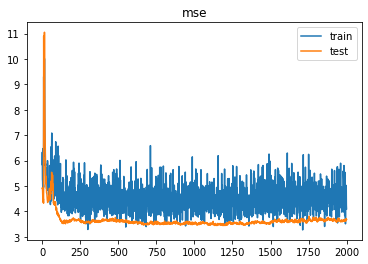

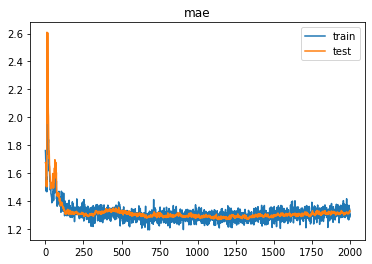

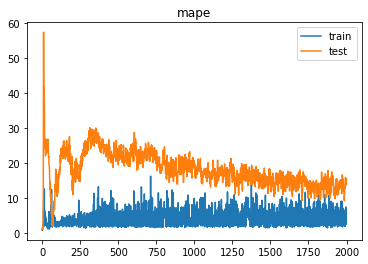

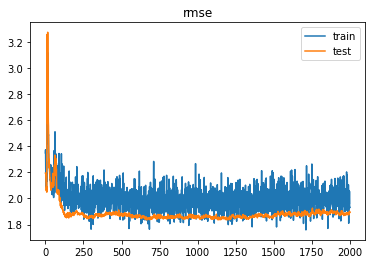

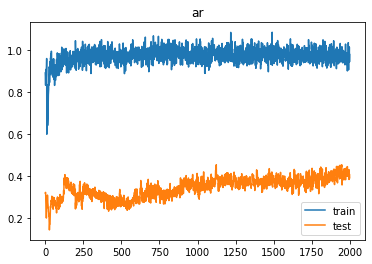

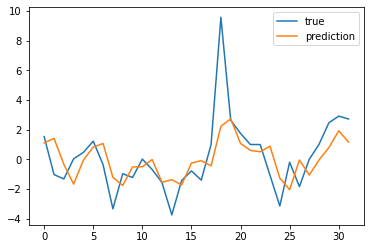

[MSE Baseline] train: 3.4933122809355592  test: 3.400572607884681
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [ 0.58270669  1.51713538  3.07355046  3.43922758  1.27226138 15.06675243
  1.83621764  0.38907963]


In [0]:
i = 1
data_name = data_names[i]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)[1768:].dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

#IBM

stock_market_GAN/datasets/IBM.csv
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_7 (Ba

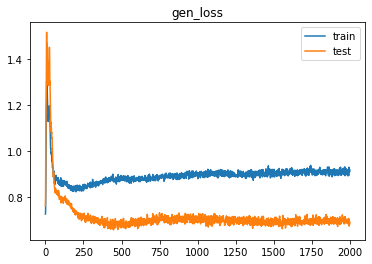

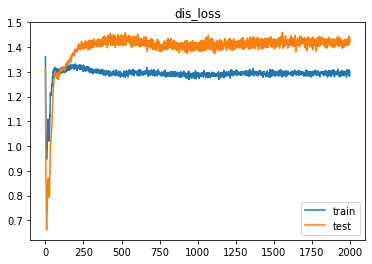

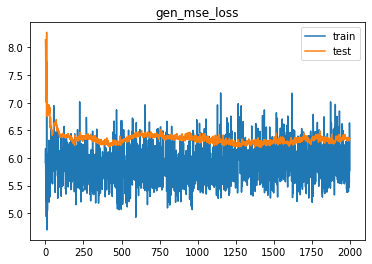

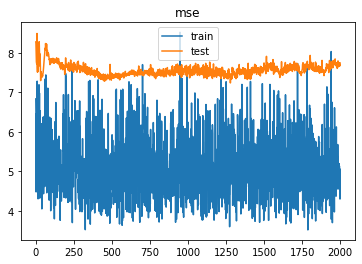

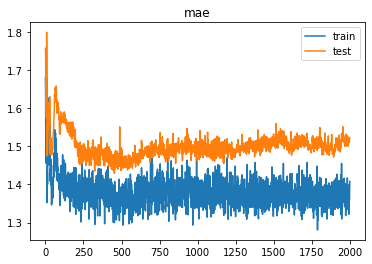

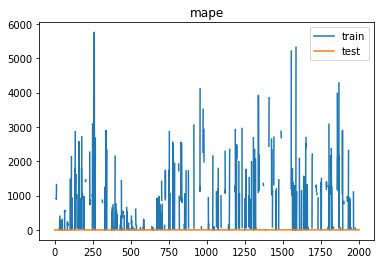

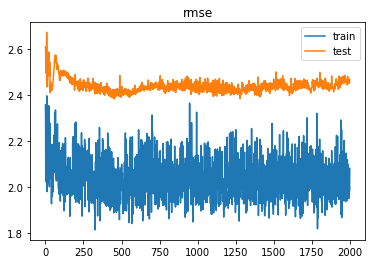

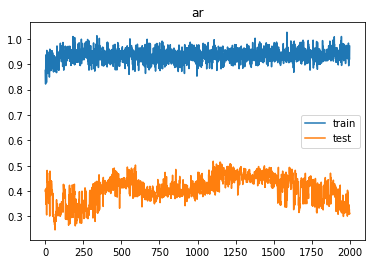

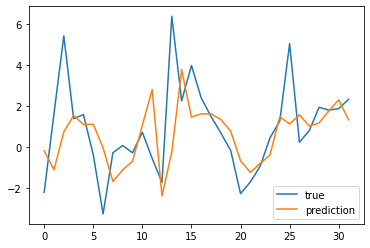

[MSE Baseline] train: 5.966140855051107  test: 7.21838560786042
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.7054143  1.41040874 6.2018671  7.23597145 1.47425425 2.16105223
 2.3845551  0.49111024]


In [0]:
i = 2
data_name = data_names[i]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

#MSFT

stock_market_GAN/datasets/MSFT.csv
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_9 (B

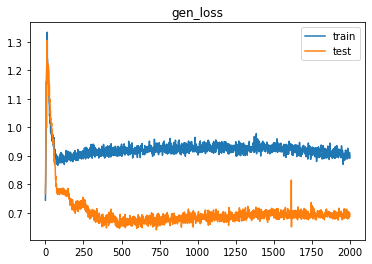

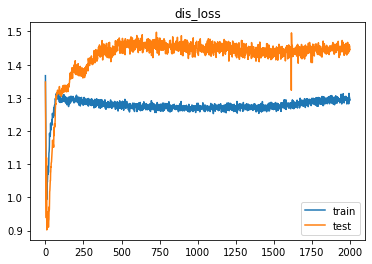

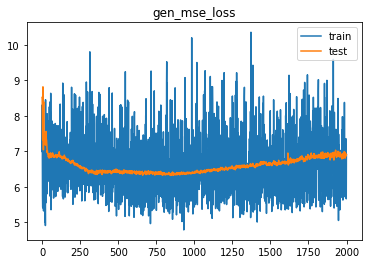

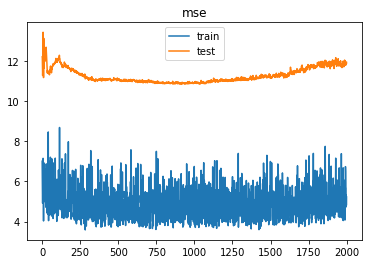

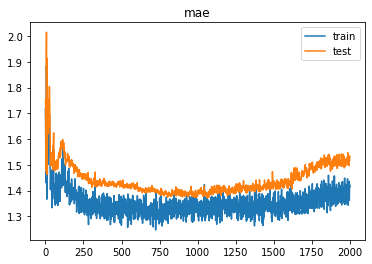

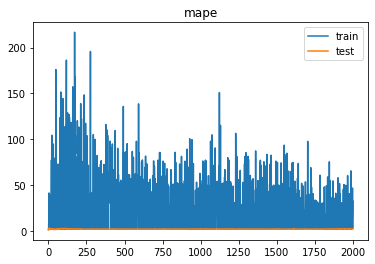

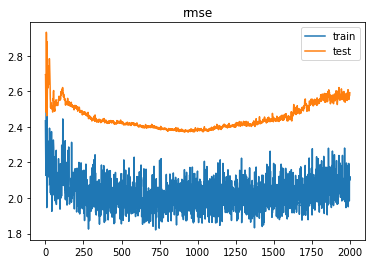

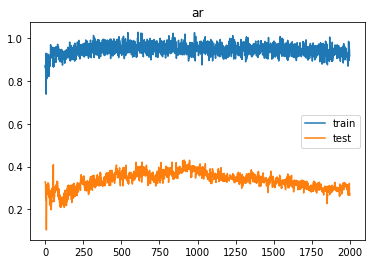

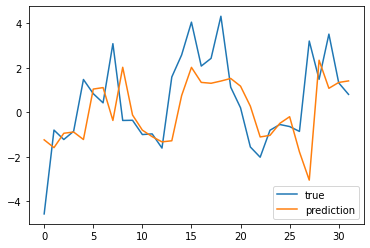

[MSE Baseline] train: 3.9041937697074722  test: 10.894685014299522
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [ 0.68676907  1.4507916   6.33753204 10.87034512  1.37878263  1.92022491
  2.3779037   0.41814315]


In [0]:
i = 3
data_name = data_names[i]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

#PAICC

stock_market_GAN/datasets/PAICC.csv
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                840       
_________________________________________________________________
batch_normalization_11 

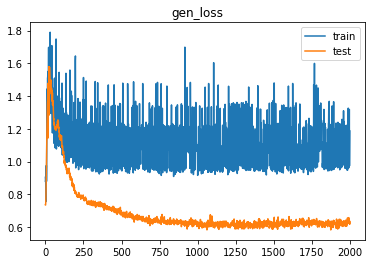

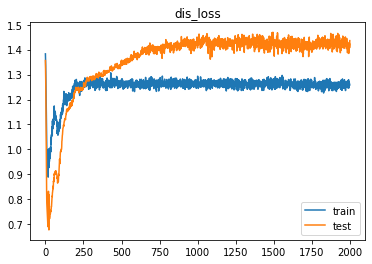

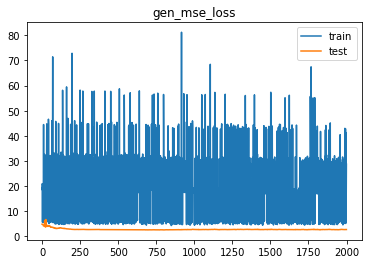

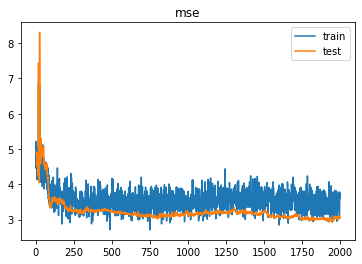

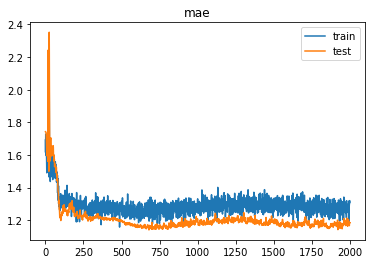

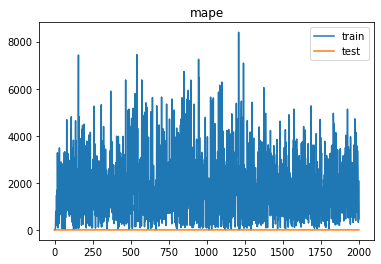

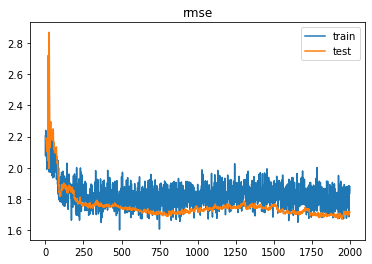

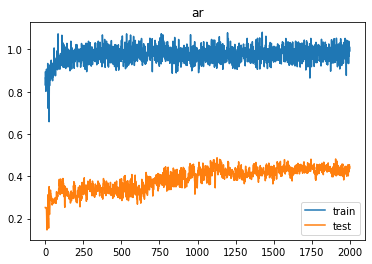

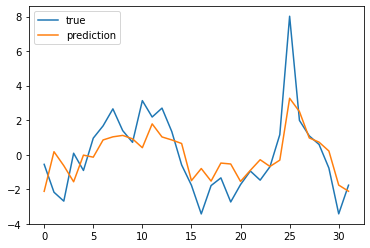

[MSE Baseline] train: 3.416640058323613  test: 2.959099180778666
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.63510144 1.41714025 2.6730113  2.9242897  1.15208459 1.17746925
 1.67052519 0.45756754]


In [0]:
i = 4
data_name = data_names[i]
data_path="stock_market_GAN/datasets/"+data_name+".csv"
print(data_path)

#datos estaticos en dataframe[1479:1524]
dataframe = pd.read_csv(data_path)[1534:].dropna()

dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

## Results

In [0]:
df = pd.DataFrame(data = results, index = data_names, columns = metrics)
df.loc['mean'] = results.mean(axis=0)
df

,gen_loss,dis_loss,gen_mse_loss,mse,mae,mape,rmse,ar
S&P500,0.657679,1.702341,3.457343,3.827636,1.259045,1.649910,1.893920,0.320345
SSE,0.582707,1.517135,3.073550,3.439228,1.272261,15.066752,1.836218,0.389080
IBM,0.705414,1.410409,6.201867,7.235971,1.474254,2.161052,2.384555,0.491110
MSFT,0.686769,1.450792,6.337532,10.870345,1.378783,1.920225,2.377904,0.418143
PAICC,0.635101,1.417140,2.673011,2.924290,1.152085,1.177469,1.670525,0.457568
mean,0.653534,1.499563,4.348661,5.659494,1.307286,4.395082,2.032624,0.415249
